Alunos:


*   Davi Bandeca Schwingel
*   Guilherme Negrini Marques

**Categoria**: Classificação não-supervisionada\
**Título**: "Application of k-Means Clustering algorithm for
prediction of Students’ Academic Performance"



# **Discussão Inicial**

**Problemas**
* Os autores aplicam a técnica de clusterização sobre dados acadêmicos de alunos em instituições privadas da Nigéria, e, dada tal conjectura, não divulgam esses dados, sendo assim, a reprodutibilidade não pôde ser alcançada.
* Estabelecem como critério de parada a convergência para o centróide ótimo global, o que não é uma abordagem ideal para datasets grandes. Como aplicam em um dataset com 79 amostras, a escolha por essa abordagem é justificável.
* A análise é muito superficial, não discutem sobre futuras melhorias e também não comentam sobre o tempo de execução e a escalabilidade em conjunto de dados de altas dimensõea.


**Nossa Abordagem**
* Foi escolhido um conjunto de dados sobre a performance acadêmica de alunos nos Estados Unidos. Ele está disponível na plataforma Kaggle, para uma melhor análise clique [aqui](https://www.kaggle.com/datasets/spscientist/students-performance-in-exams/data/code).
* O dataset possui 3 campos numéricos que foram utilizados para a execução do algoritmo: pontuação em leitura, pontuação em escrita e pontuação em matemática.
* Os centróides foram iniciados de maneira aleatória, e ao fim, a performance geral de cada centróide será exibida.
* Por fim, foi empregada uma técnica que utiliza PCA, chamada PCA-Part para determinação do centróide inicial. Ao fim, uma comparação entre ambas (aleatória e com PCA) foi conduzida, analisando sua convergência e o tempo de execução.







# **Referências**

Celebi, M Emre, Hassan A Kingravi e Patricio A Vela. 2013. “A comparative study of efficient initialization methods for the k-means clustering algorithm” Expert systems with applications 40 (1): 200–210.

Oyelade, Olanrewaju Jelili, Olufunke O Oladipupo e Ibidun Christiana Obagbuwa. 2010. “Application of k Means Clustering algorithm for prediction of Students Academic Performance”. arXiv preprint arXiv:1002.2425.

Su, Ting e Jennifer G Dy. 2007. “In search of deterministic methods for initializing K-means and Gaussian mixture clustering”. Intelligent Data Analysis 11 (4): 319–338.

# **Código**

In [ ]:
import kagglehub
import os
import time
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import davies_bouldin_score

In [ ]:
# get dataset

def get_dataset() -> str:

    path = kagglehub.dataset_download("spscientist/students-performance-in-exams")

    return path



In [ ]:
# algoritmo k_means de acordo com o paper "Application of k-Means Clustering algorithm for prediction of Students’ Academic Performance"
from typing import Tuple
class KMEANS:
    """
    Implementação customizada do algoritmo K-Means, incluindo inicialização PCA-Part.
    O MSE (Mean Squared Error) corresponde à métrica WCSS (Within-Cluster Sum of Squares) ou Inércia.
    """
    def __init__(self, dataset: pd.DataFrame) -> None:

        # Conjunto de dados (DataFrame ou array de features padronizadas/transformadas)
        self.dataset = dataset


    def _definir_centroides_iniciais(self, k: int) -> np.ndarray:
        """
        Método de inicialização 'random': Escolhe k pontos aleatórios como centróides iniciais.
        """
        possibilidades = np.array([i for i in range(self.dataset.shape[0])])

        # Escolhe k índices únicos
        idx_escolhidos = np.random.choice(possibilidades, size=k, replace=False)

        return idx_escolhidos

    def _definir_centroides_pca(self, k: int) -> np.ndarray:
        """
        Implementa a inicialização PCA-Part.
        O método encontra os k centróides através de divisões sucessivas baseadas
        no componente principal de maior variância.
        """
        X = self.dataset.values
        n_samples, n_features = X.shape

        # Inicialmente, todos os pontos pertencem a um único cluster
        clusters_indices = [np.arange(n_samples)]

        # Divide até ter k clusters
        while len(clusters_indices) < k:
            max_sse = -1
            cluster_to_split_idx = -1

            # Passo de seleção: escolher o cluster com maior SSE intra-cluster
            for i, indices in enumerate(clusters_indices):
                if len(indices) < 2: # Não é possível dividir clusters com 0 ou 1 ponto
                    continue

                sse = self._calcular_sse_cluster(X[indices])
                if sse > max_sse:
                    max_sse = sse
                    cluster_to_split_idx = i

            if cluster_to_split_idx == -1:
                break # Não há mais clusters divisíveis

            # Passo de divisão: Dividir o cluster escolhido
            indices_atual = clusters_indices.pop(cluster_to_split_idx)
            dados_atual = X[indices_atual]

            # Calcular a matriz de covariância e o maior autovetor
            if dados_atual.shape[0] > 1:

                # Certificar que a matriz de covariância é calculável
                if dados_atual.shape[0] == 1:
                    cov_matrix = np.zeros((dados_atual.shape[1], dados_atual.shape[1]))
                elif dados_atual.shape[1] == 1:
                    cov_matrix = np.array([[np.var(dados_atual)]])
                else:
                    cov_matrix = np.cov(dados_atual, rowvar=False)

                # Calcular autovalores e autovetores
                try:
                    eigvals, eigvecs = np.linalg.eigh(cov_matrix)
                    principal_component = eigvecs[:, np.argmax(eigvals)]
                except np.linalg.LinAlgError:
                     # Fallback se a matriz for singular ou houver erro
                    principal_component = np.ones(dados_atual.shape[1]) / np.sqrt(dados_atual.shape[1])


                # Projetar os dados no autovetor
                projecao = np.dot(dados_atual, principal_component)

                # Dividir pela mediana ou média (média é comum, mas PCA-Part geralmente usa o ponto de corte)
                limiar = np.mean(projecao)
                mascara_grupo1 = projecao <= limiar

                indices_grupo1 = indices_atual[mascara_grupo1]
                indices_grupo2 = indices_atual[~mascara_grupo1]

                # Caso a divisão resulte em um grupo vazio
                if len(indices_grupo1) == 0 or len(indices_grupo2) == 0:
                     # Forçar divisão por índice se a divisão da projeção falhar
                     indices_grupo1, indices_grupo2 = np.array_split(indices_atual, 2)

                     # Verifica se a divisão forçada ainda resultou em sub-arrays vazios
                     if len(indices_grupo1) == 0 and len(indices_grupo2) > 0:
                         indices_grupo1 = indices_grupo2[:1]
                         indices_grupo2 = indices_grupo2[1:]
                     elif len(indices_grupo2) == 0 and len(indices_grupo1) > 0:
                         indices_grupo2 = indices_grupo1[:1]
                         indices_grupo1 = indices_grupo1[1:]


                clusters_indices.append(indices_grupo1)
                clusters_indices.append(indices_grupo2)
            else:
                 clusters_indices.append(indices_atual)

        # Calcular os centróides finais (média dos pontos em cada cluster obtido)
        indices_escolhidos = []
        for indices in clusters_indices:
            if len(indices) == 0:
                continue

            dados_cluster = X[indices]
            centroide_medio = np.mean(dados_cluster, axis=0)

            # Encontrar o ponto do dataset original mais próximo deste centróide calculado
            # (Melhor método para inicializar centróides)
            distancias = self._squared_euclidean_distance(X, centroide_medio[None,:]) # Comparar contra todos os pontos
            idx_mais_proximo = np.argmin(distancias)
            indices_escolhidos.append(idx_mais_proximo)

        # Garante que temos exatamente k centróides
        if len(indices_escolhidos) > k:
            return np.array(indices_escolhidos[:k])
        elif len(indices_escolhidos) < k:
             # Se menos de k centróides foram encontrados, preenche com aleatórios
             faltantes = k - len(indices_escolhidos)
             indices_aleatorios = np.random.choice(n_samples, size=faltantes, replace=False)
             return np.concatenate((indices_escolhidos, indices_aleatorios))

        return np.array(indices_escolhidos)

    def _calcular_sse_cluster(self, dados_cluster: np.ndarray) -> float:
        """Calcula o Sum of Squared Errors (SSE) de um grupo de dados em relação à sua média."""
        if len(dados_cluster) == 0:
            return 0.0
        media = np.mean(dados_cluster, axis=0)
        # SSE = WCSS
        sse = np.sum((dados_cluster - media)**2)
        return sse


    def _squared_euclidean_distance(self, X: np.ndarray, Y: np.ndarray) -> np.ndarray:
        """
        Calcula a distância euclidiana ao quadrado entre um ponto X e os centróides Y.
        """
        # Se X for um vetor de 1D, garante que seja 2D para subtração broadcast
        if X.ndim == 1:
            X = X[None, :]
        return np.sum((X[:, None, :] - Y[None, :, :])**2, axis=2)

    def _run(self, k:int, initial_centroids: np.array, max_iterations: int):
       """ Executa o algoritmo K-Means """
       X = self.dataset.values
       n_amostras, n_features = X.shape

       centroids = X[initial_centroids]

       MSE = np.inf # WCSS (Inércia)
       OLD_MSE = np.inf

       cluster_assignments = np.zeros(n_amostras, dtype=int)

       # Loop principal do K-Means
       for iteration in range(max_iterations):
           # Se a inércia não melhorou (convergiu)
           if iteration > 0 and MSE >= OLD_MSE:
               break

           OLD_MSE = MSE
           MSE1 = 0 # Novo WCSS/MSE

           m_j = np.zeros((k, n_features)) # Soma dos pontos por cluster
           n_j = np.zeros(k)              # Contagem de pontos por cluster

           # 1. Passo de Atribuição (Assignment)
           for i in range(n_amostras):
               x_i = X[i]

               # Calcula a distância euclidiana ao quadrado para todos os centróides
               distancias_sq = self._squared_euclidean_distance(x_i, centroids).flatten()

               # Encontra o centróide mais próximo
               centroide_mais_proximo_idx = np.argmin(distancias_sq)
               cluster_assignments[i] = centroide_mais_proximo_idx

               # Acumula para o cálculo do novo centróide e do WCSS
               m_j[centroide_mais_proximo_idx] += x_i
               n_j[centroide_mais_proximo_idx] += 1

               MSE1 += distancias_sq[centroide_mais_proximo_idx]

           # 2. Passo de Atualização (Update)
           novos_centroides = np.zeros((k, n_features))

           for j in range(k):
               count = max(n_j[j], 1) # Evitar divisão por zero
               novos_centroides[j] = m_j[j] / count

           MSE = MSE1
           centroids = novos_centroides

       # Retorna os rótulos, os centróides e o WCSS (Inércia)
       return cluster_assignments, centroids, MSE



    def __call__(self, k: int, seed: int = 42, max_iterations: int = 100, init_method: str = 'random') -> Tuple[np.ndarray, float]:
        """
            Executa a inicialização e o algoritmo K-Means.
            Retorna: (rótulos de cluster, WCSS/Inércia)
        """
        np.random.seed(seed)

        try:
            if init_method == 'random':
                idx_centroides = self._definir_centroides_iniciais(k=k)

            elif init_method == 'pca':
                idx_centroides = self._definir_centroides_pca(k=k)

            # Note a desempacotamento correto dos 3 retornos de _run
            clusters_resultantes, centroides_finais, wcss = self._run(
                k=k,
                initial_centroids=idx_centroides,
                max_iterations=max_iterations
            )

            return clusters_resultantes, wcss


        except Exception as e:
            print(f"Erro durante a execução do K-Means: {e}")
            raise Exception('Algo deu errado')

In [ ]:

def analisar_clusters(df_final: pd.DataFrame, df_original: pd.DataFrame, k: int, seed: int, max_iterations: int, init_method: str = 'random') -> tuple[pd.DataFrame, float, float]:
    """
    Executa o K-Means customizado, calcula DBI e WCSS, e realiza análise de desempenho por cluster.

    Retorna: (DataFrame com análise por cluster, WCSS, DBI)
    """

    kmeans = KMEANS(dataset=df_final)

    tempo_ini = time.time()
    cluster_labels, wcss = kmeans(
        k=k,
        seed=seed,
        max_iterations=max_iterations,
        init_method=init_method
    )
    tempo_fim = time.time()
    tempo_execucao = tempo_fim - tempo_ini
    print(f"Execução com k={k}, abordagem={init_method} e seed={seed}: {tempo_execucao} s")

    if k > 1 and len(np.unique(cluster_labels)) > 1:
        dbi_score = davies_bouldin_score(df_final, cluster_labels)
    else:
        dbi_score = np.nan

    # ----------------------------------------------------------------------


    df_analise = df_original.copy()
    df_analise['Cluster'] = cluster_labels

    score_cols = ['math score', 'reading score', 'writing score']
    df_analise['Overall Performance'] = df_analise[score_cols].mean(axis=1)

    resultados = df_analise.groupby('Cluster').agg(
        cluster_size=('Cluster', 'size'), #tamanho do cluster
        overall_performance=('Overall Performance', 'mean') #média do desempenho
    ).reset_index()

    resultados.columns = ['Cluster #', 'Cluster size', 'Overall Performance']

    resultados['Overall Performance'] = resultados['Overall Performance'].round(2)

    # Retorna o DataFrame de análise de cluster, WCSS e DBI
    return resultados, wcss, dbi_score

In [ ]:
def format_metrics_table(k: int, init_method: str, wcss: float, dbi: float):
    """Formata as métricas gerais em uma tabela Markdown."""
    data = {
        'Métrica': ['K', 'WCSS (Inércia/MSE)', 'DBI (Davies-Bouldin)', 'Inicialização'],
        'Valor': [k, f"{wcss:.4f}", f"{dbi:.4f}" if not np.isnan(dbi) else 'N/A', init_method]
    }
    return pd.DataFrame(data)

In [ ]:
if __name__ == '__main__':
    path = get_dataset()
    nome_do_arquivo = 'StudentsPerformance.csv'
    caminho_completo = os.path.join(path, nome_do_arquivo)
    df = pd.read_csv(caminho_completo)


    score_cols = ['math score', 'reading score', 'writing score']
    dados_para_k_means = df[score_cols].copy()
    scaler = MinMaxScaler()

    dados_escalados = scaler.fit_transform(dados_para_k_means)

    #fit_transform nos retornará um array, assim devemos converter novamente para um DataFrame

    df_final = pd.DataFrame(dados_escalados, columns=dados_para_k_means.columns)


    resultados_k3_random, wcss_k3_random, dbi_k3_random = analisar_clusters(df_final=df_final,
                                      df_original=df,
                                      k=3,
                                      seed=42,
                                      max_iterations=300,
                                      #init_method='pca'
                                      )

    print("\n-------Análise por Cluster (K=3, Inicialização Aleatória)--------------")
    print(resultados_k3_random.to_markdown(index=False))

    print("\n-------Métricas Gerais (K=3, Inicialização Aleatória)--------------")
    print(format_metrics_table(3, 'random', wcss_k3_random, dbi_k3_random).to_markdown(index=False))

    resultados_k4_random, wcss_k4_random, dbi_k4_random = analisar_clusters(df_final=df_final,
                                      df_original=df,
                                      k=4,
                                      seed=42,
                                      max_iterations=300,
                                      #init_method='pca'
                                      )

    print("\n-------Análise por Cluster (K=4, Inicialização Aleatória)--------------")
    print(resultados_k4_random.to_markdown(index=False))

    print("\n-------Métricas Gerais (K=4, Inicialização Aleatória)--------------")
    print(format_metrics_table(4, 'random', wcss_k4_random, dbi_k4_random).to_markdown(index=False))



    resultados_k5_random, wcss_k5_random, dbi_k5_random = analisar_clusters(df_final=df_final,
                                      df_original=df,
                                      k=5,
                                      seed=42,
                                      max_iterations=300,
                                      #init_method='pca'
                                      )

    print("\n-------Análise por Cluster (K=5, Inicialização Aleatória)--------------")
    print(resultados_k5_random.to_markdown(index=False))

    print("\n-------Métricas Gerais (K=5, Inicialização Aleatória)--------------")
    print(format_metrics_table(5, 'random', wcss_k5_random, dbi_k5_random).to_markdown(index=False))



Using Colab cache for faster access to the 'students-performance-in-exams' dataset.
Execução com k=3, abordagem=random e seed=42: 1.4062764644622803 s

-------Análise por Cluster (K=3, Inicialização Aleatória)--------------
|   Cluster # |   Cluster size |   Overall Performance |
|------------:|---------------:|----------------------:|
|           0 |            303 |                 83.81 |
|           1 |            262 |                 49.56 |
|           2 |            435 |                 67.56 |

-------Métricas Gerais (K=3, Inicialização Aleatória)--------------
| Métrica              | Valor   |
|:---------------------|:--------|
| K                    | 3       |
| WCSS (Inércia/MSE)   | 21.1611 |
| DBI (Davies-Bouldin) | 0.7833  |
| Inicialização        | random  |
Execução com k=4, abordagem=random e seed=42: 1.4474678039550781 s

-------Análise por Cluster (K=4, Inicialização Aleatória)--------------
|   Cluster # |   Cluster size |   Overall Performance |
|------------:|

In [ ]:
if __name__ == '__main__':
    path = get_dataset()
    nome_do_arquivo = 'StudentsPerformance.csv'
    caminho_completo = os.path.join(path, nome_do_arquivo)
    df = pd.read_csv(caminho_completo)


    score_cols = ['math score', 'reading score', 'writing score']
    dados_para_k_means = df[score_cols].copy()
    scaler = MinMaxScaler()

    dados_escalados = scaler.fit_transform(dados_para_k_means)

    #fit_transform nos retornará um array, assim devemos converter novamente para um DataFrame

    df_final = pd.DataFrame(dados_escalados, columns=dados_para_k_means.columns)


    resultados_k3_pca, wcss_k3_pca, dbi_k3_pca = analisar_clusters(df_final=df_final,
                                      df_original=df,
                                      k=3,
                                      seed=42,
                                      max_iterations=300,
                                      init_method='pca'
                                      )

    print("\n-------Análise por Cluster (K=3, PCA)--------------")
    print(resultados_k3_pca.to_markdown(index=False))

    print("\n-------Métricas Gerais (K=3, PCA)--------------")
    print(format_metrics_table(3, 'PCA', wcss_k3_pca, dbi_k3_pca).to_markdown(index=False))

    resultados_k4_pca, wcss_k4_pca, dbi_k4_pca = analisar_clusters(df_final=df_final,
                                      df_original=df,
                                      k=4,
                                      seed=42,
                                      max_iterations=300,
                                      init_method='pca'
                                      )

    print("\n-------Análise por Cluster (K=4, PCA)--------------")
    print(resultados_k4_pca.to_markdown(index=False))

    print("\n-------Métricas Gerais (K=4, PCA)--------------")
    print(format_metrics_table(4, 'PCA', wcss_k4_pca, dbi_k4_pca).to_markdown(index=False))



    resultados_k5_pca, wcss_k5_pca, dbi_k5_pca = analisar_clusters(df_final=df_final,
                                      df_original=df,
                                      k=5,
                                      seed=42,
                                      max_iterations=300,
                                      init_method='pca'
                                      )

    print("\n-------Análise por Cluster (K=5, PCA)--------------")
    print(resultados_k5_random.to_markdown(index=False))

    print("\n-------Métricas Gerais (K=5, PCA)--------------")
    print(format_metrics_table(5, 'PCA', wcss_k5_pca, dbi_k5_pca).to_markdown(index=False))



Using Colab cache for faster access to the 'students-performance-in-exams' dataset.
Execução com k=3, abordagem=pca e seed=42: 0.7790377140045166 s

-------Análise por Cluster (K=3, PCA)--------------
|   Cluster # |   Cluster size |   Overall Performance |
|------------:|---------------:|----------------------:|
|           0 |            310 |                 83.62 |
|           1 |            429 |                 67.41 |
|           2 |            261 |                 49.53 |

-------Métricas Gerais (K=3, PCA)--------------
| Métrica              | Valor   |
|:---------------------|:--------|
| K                    | 3       |
| WCSS (Inércia/MSE)   | 21.1587 |
| DBI (Davies-Bouldin) | 0.7851  |
| Inicialização        | PCA     |
Execução com k=4, abordagem=pca e seed=42: 0.4068734645843506 s

-------Análise por Cluster (K=4, PCA)--------------
|   Cluster # |   Cluster size |   Overall Performance |
|------------:|---------------:|----------------------:|
|           0 |         

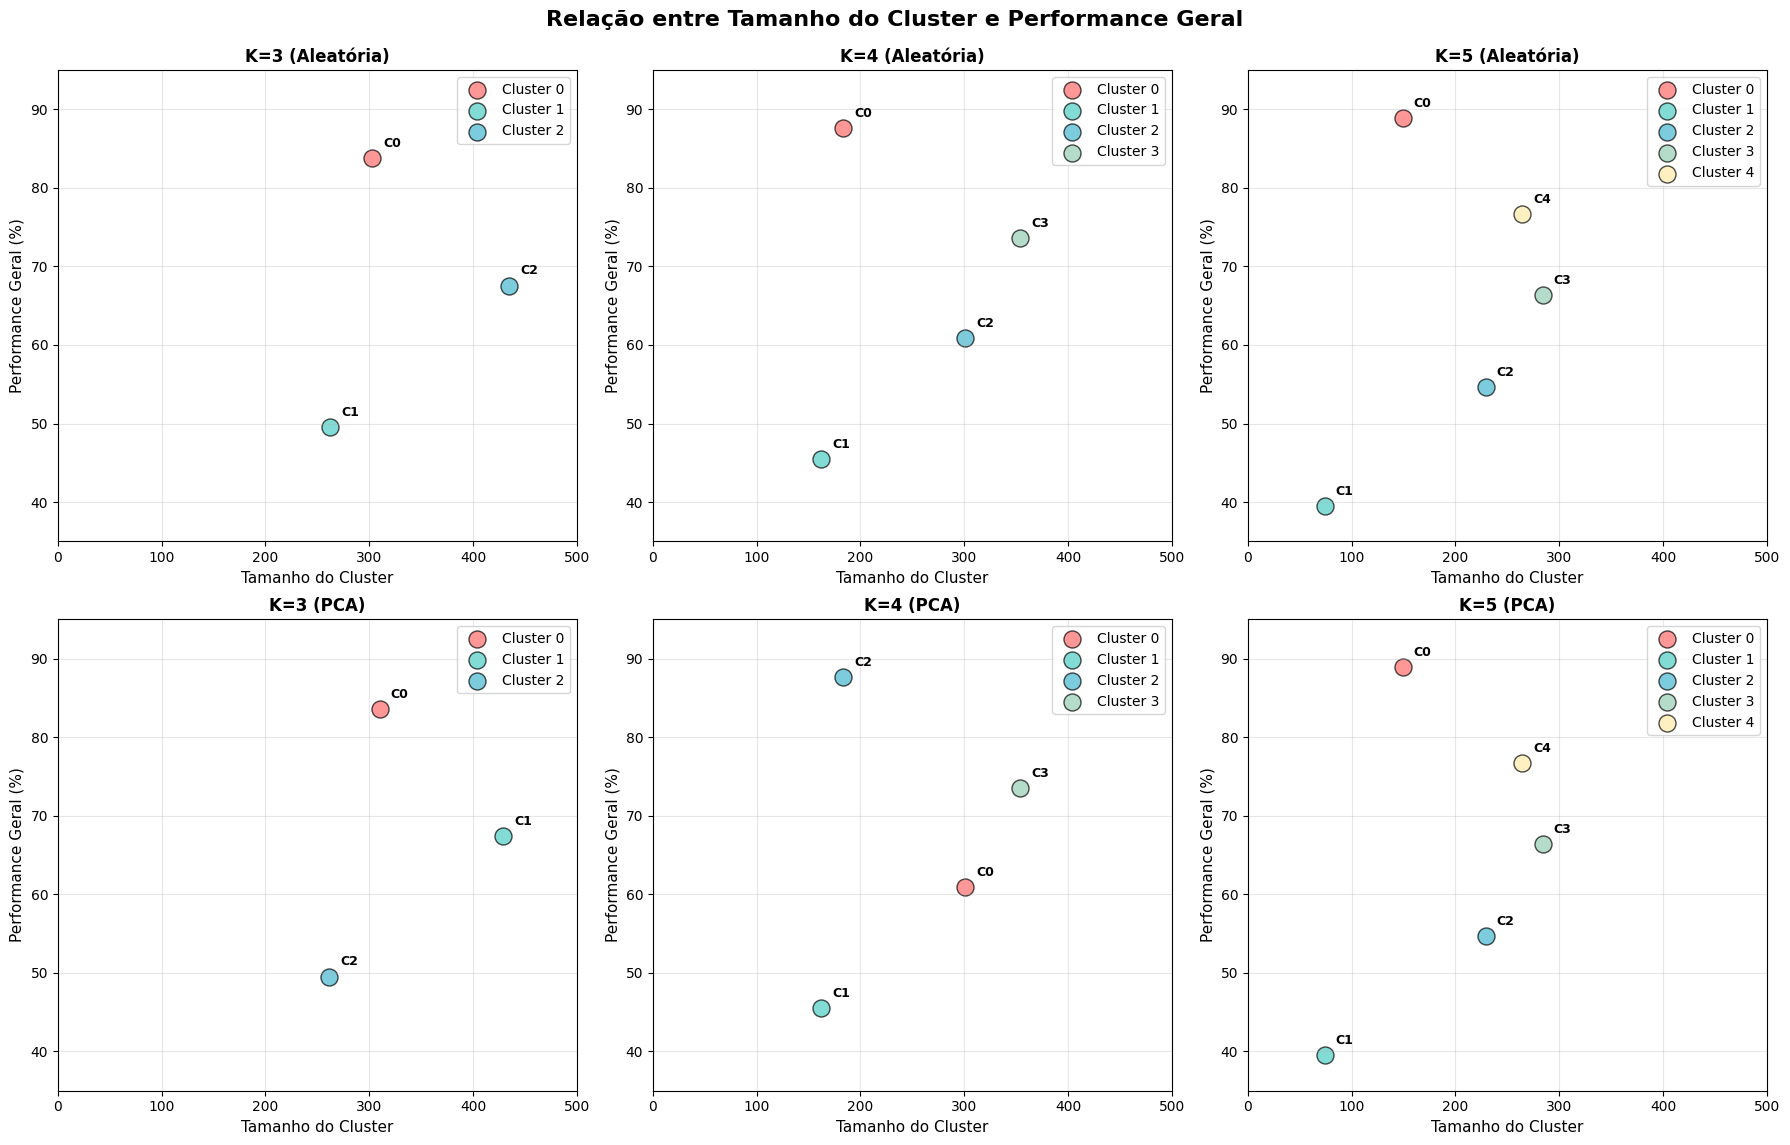

1. Clusters menores tendem a ter performance mais extrema (alta ou baixa)
2. Clusters maiores geralmente apresentam performance intermediária
3. O método de inicialização não afeta significativamente a relação tamanho-performance
4. À medida que K aumenta, os clusters se tornam mais especializados em faixas específicas de performance


In [ ]:
import matplotlib.pyplot as plt
import numpy as np


dados_graficos = {
    'k3_random': {
        'tamanhos': [303, 262, 435],
        'performances': [83.81, 49.56, 67.56],
        'clusters': [0, 1, 2]
    },
    'k4_random': {
        'tamanhos': [183, 162, 301, 354],
        'performances': [87.61, 45.5, 60.89, 73.56],
        'clusters': [0, 1, 2, 3]
    },
    'k5_random': {
        'tamanhos': [149, 74, 229, 284, 264],
        'performances': [88.91, 39.5, 54.65, 66.37, 76.66],
        'clusters': [0, 1, 2, 3, 4]
    },
    'k3_pca': {
        'tamanhos': [310, 429, 261],
        'performances': [83.62, 67.41, 49.53],
        'clusters': [0, 1, 2]
    },
    'k4_pca': {
        'tamanhos': [301, 162, 183, 354],
        'performances': [60.89, 45.5, 87.61, 73.56],
        'clusters': [0, 1, 2, 3]
    },
    'k5_pca': {
        'tamanhos': [149, 74, 229, 284, 264],
        'performances': [88.91, 39.5, 54.65, 66.37, 76.66],
        'clusters': [0, 1, 2, 3, 4]
    }
}

# Cada cluster terá uma cor diferente
cores = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD']

# Criar figura com 2 linhas e 3 colunas
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Relação entre Tamanho do Cluster e Performance Geral', fontsize=16, fontweight='bold', y=0.95)


configuracoes = [
    ('k3_random', 'K=3 (Aleatória)', axes[0, 0]),
    ('k4_random', 'K=4 (Aleatória)', axes[0, 1]),
    ('k5_random', 'K=5 (Aleatória)', axes[0, 2]),
    ('k3_pca', 'K=3 (PCA)', axes[1, 0]),
    ('k4_pca', 'K=4 (PCA)', axes[1, 1]),
    ('k5_pca', 'K=5 (PCA)', axes[1, 2])
]

for config, titulo, ax in configuracoes:
    dados = dados_graficos[config]
    tamanhos = dados['tamanhos']
    performances = dados['performances']
    clusters = dados['clusters']

    # para cada ponto
    for i, (tamanho, performance, cluster) in enumerate(zip(tamanhos, performances, clusters)):
        ax.scatter(
            tamanho,
            performance,
            s=150,
            color=cores[i],
            alpha=0.7,
            edgecolor='black',
            linewidth=1,
            label=f'Cluster {cluster}'
        )


        ax.annotate(
            f'C{cluster}',
            (tamanho, performance),
            xytext=(8, 8),
            textcoords='offset points',
            fontsize=9,
            fontweight='bold'
        )

    # Configurações do gráfico
    ax.set_xlabel('Tamanho do Cluster', fontsize=11)
    ax.set_ylabel('Performance Geral (%)', fontsize=11)
    ax.set_title(titulo, fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend()


    ax.set_xlim(0, 500)
    ax.set_ylim(35, 95)

plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()

# Gráfico comparativo único
plt.figure(figsize=(14, 8))

marcadores = ['o', 's', 'D', '^', 'v', '<']
cores_metodos = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

for idx, (config, dados) in enumerate(dados_graficos.items()):
    k = int(config[1])
    metodo = 'Aleatória' if 'random' in config else 'PCA'
    marcador = marcadores[idx % len(marcadores)]
    cor = cores_metodos[idx % len(cores_metodos)]

    for i, (tamanho, performance, cluster) in enumerate(zip(dados['tamanhos'], dados['performances'], dados['clusters'])):
        plt.scatter(
            tamanho,
            performance,
            s=120,
            color=cor,
            marker=marcador,
            alpha=0.7,
            edgecolor='black',
            linewidth=0.5,
            label=f'K={k} {metodo} - C{cluster}' if i == 0 else ""
        )

plt.xlabel('Tamanho do Cluster', fontsize=12, fontweight='bold')
plt.ylabel('Performance Geral (%)', fontsize=12, fontweight='bold')
plt.title('Comparação Geral: Tamanho vs Performance por Configuração', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


print("1. Clusters menores tendem a ter performance mais extrema (alta ou baixa)")
print("2. Clusters maiores geralmente apresentam performance intermediária")
print("3. O método de inicialização não afeta significativamente a relação tamanho-performance")
print("4. À medida que K aumenta, os clusters se tornam mais especializados em faixas específicas de performance")